In [ ]:
# Графики к лекции про метод Монте-Карло и дополнению про схему QE для модели Хестона 

%load_ext autoreload
%autoreload 2
from math import *
import numpy as np
import scipy.stats as st
import matplotlib as mpl
import matplotlib.pyplot as plt
import cupy as cp
import cupyx as cpx

import sys
sys.path.append('../..')

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import pyfinmath as fm

plt.rcParams.update({
    "font.size": 11,
    "axes.titlesize": 8,
    "axes.labelsize": 8,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "legend.fontsize": 7,
    "figure.titlesize": 8,
    "figure.dpi": 600,
    "lines.linewidth": 1,
    "axes.linewidth": 0.6,
    "grid.linewidth": 0.3,
    "xtick.major.width": 0.6,
    "ytick.major.width": 0.6,
    "xtick.minor.width": 0.3,
    "ytick.minor.width": 0.3,
})

scale = 1     # Масштаб графиков

In [2]:
# Схема Эйлера на GPU

@cpx.jit.rawkernel()
def euler_kernel(S, V, Vplus, Z, dt, kappa, theta, sigma, rho, paths, intersteps):
    thread_id = cpx.jit.blockIdx.x * cpx.jit.blockDim.x + cpx.jit.threadIdx.x  
    total_threads = cpx.jit.gridDim.x * cpx.jit.blockDim.x                     

    for j in range(thread_id, paths, total_threads):
        if j < paths:
            for i in range(intersteps):
                Vplus[j] = max(V[j], 0)
                V[j] += kappa*(theta-Vplus[j])*dt + sigma*cp.sqrt(Vplus[j])*Z[0,i,j]*cp.sqrt(dt)
                S[j] *= cp.exp(-0.5*Vplus[j]*dt + cp.sqrt(Vplus[j])*(rho*Z[0,i,j] + cp.sqrt(1-rho**2)*Z[1,i,j])*cp.sqrt(dt))

class HestonExt(fm.Heston):
    def simulate_euler_gpu(self, initial_price, t, steps, paths, intersteps=1, cuda_tpb=512, cuda_blocks=None):
        if cuda_blocks is None:
                cuda_blocks = (paths+cuda_tpb-1)//cuda_tpb

        dt = cp.float32(t/(steps*intersteps))

        S = cp.empty(shape=(steps+1, paths), dtype=cp.float32)
        V = cp.empty_like(S, dtype=cp.float32)
        Vplus = cp.empty(paths, dtype=cp.float32)
        S[0] = cp.float32(initial_price)
        V[0] = cp.float32(self.v0)

        for i in range(steps):
            S[i+1] = S[i]
            V[i+1] = V[i]
            Z = cp.random.randn(2, intersteps, paths, dtype=cp.float32)
            euler_kernel[cuda_blocks,cuda_tpb](S[i+1], V[i+1], Vplus, Z, dt, cp.float32(self.kappa), cp.float32(self.theta), cp.float32(self.sigma), cp.float32(self.rho), paths, intersteps)

        return S

20 steps:
Euler sucess: True | paths: 72000000
100 steps:
Euler sucess: True | paths: 92000000


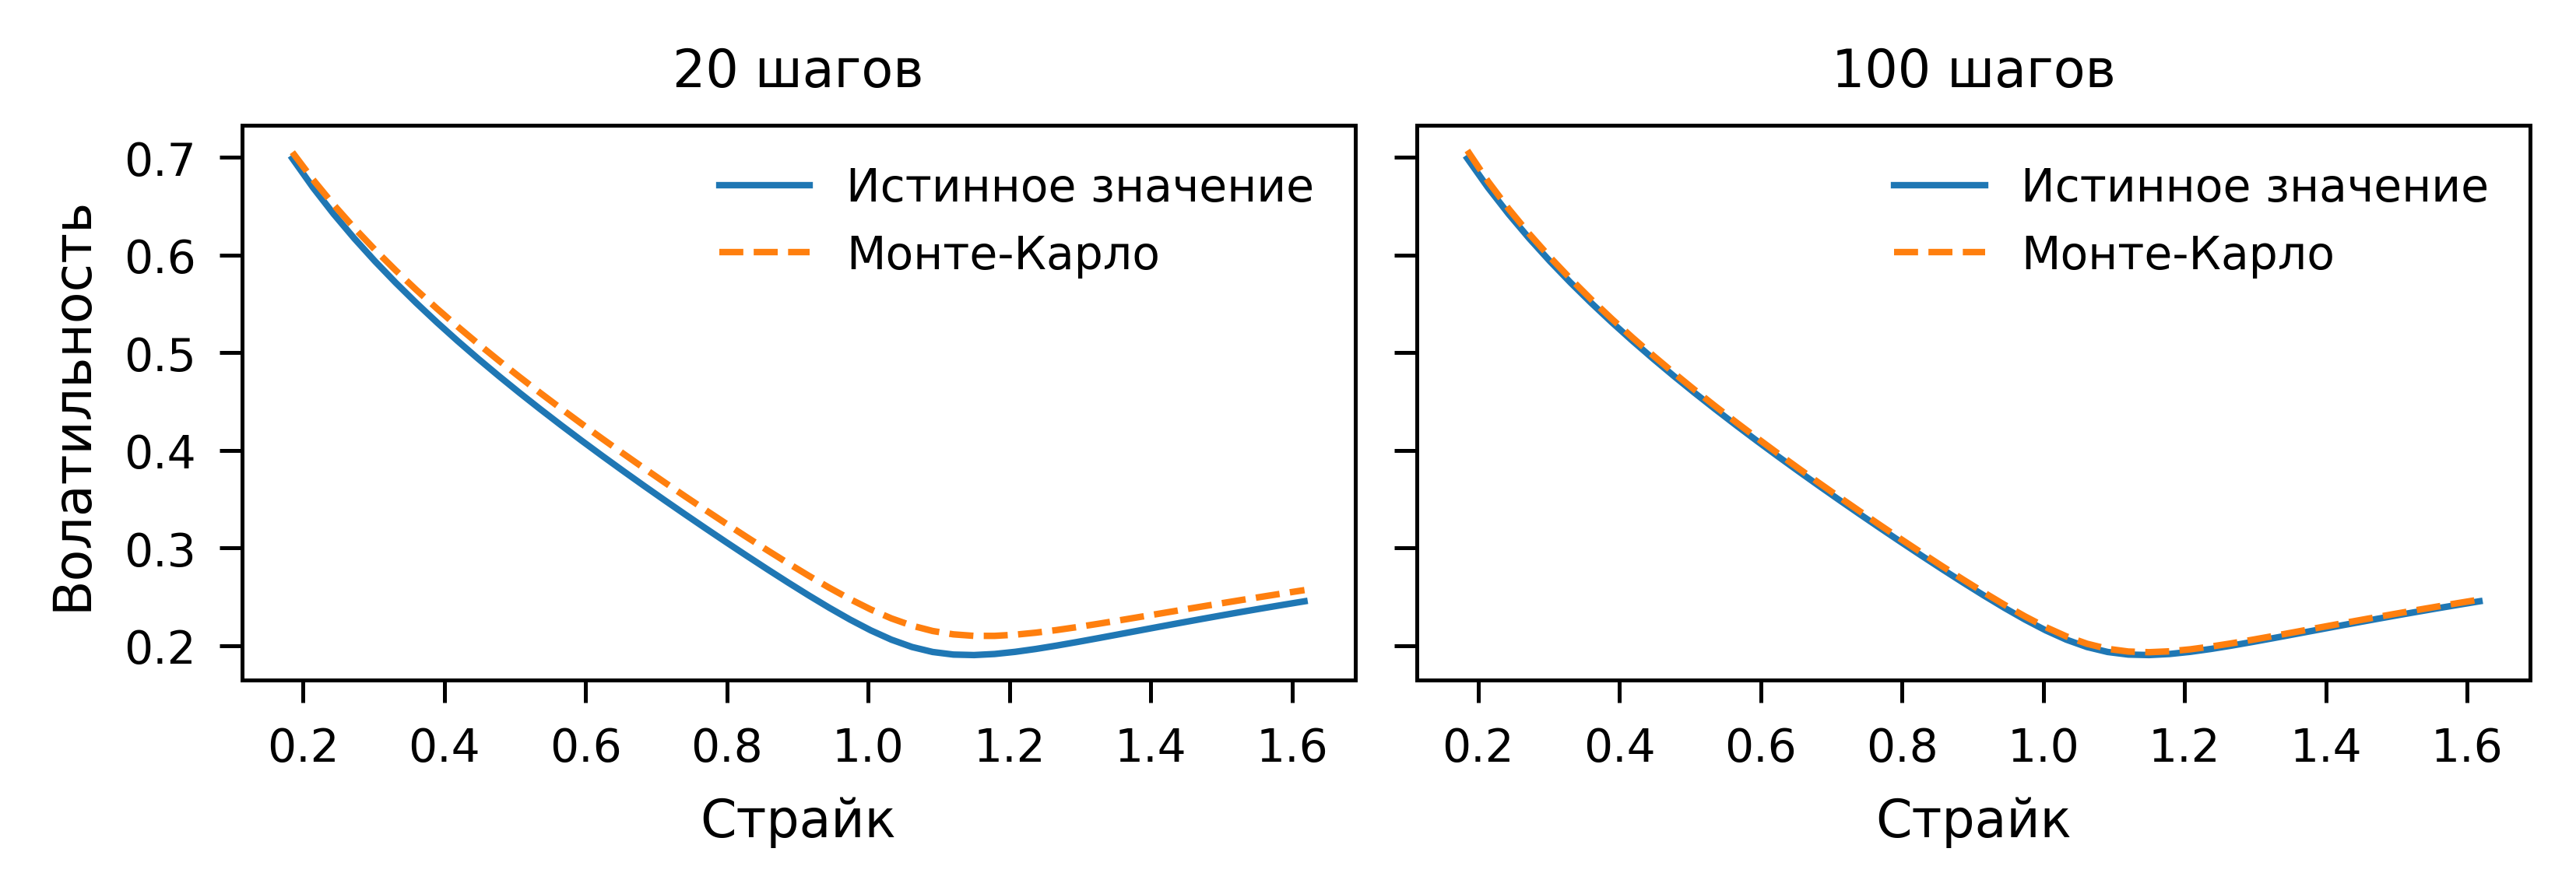

In [4]:
# Точность схемы Эйлера
model = HestonExt(0.1, 1, 0.1, 1.5, -0.6)
fig, ax = plt.subplots(1, 2, figsize=(2.7*2*scale, 1.8*1*scale), constrained_layout=True, sharey=True)

t = 1
s0 = 1
K = np.linspace(model.quantile(s0, t, 0.01), model.quantile(s0, t, 0.99), 50)
IV = model.implied_vol(s0, t, K)
for i, steps in enumerate([20, 100]):
    print(steps, 'steps:')
    res = fm.monte_carlo(lambda: np.maximum(np.subtract.outer(model.simulate_euler_gpu(s0, t, steps=1, intersteps=steps, paths=1_000_000)[-1], K), 0), 1000_000_000, rel_err=0.005)
    C = cp.asnumpy(res.x)
    IV_ = fm.implied_vol(s0, t, K, C)
    ax[i].plot(K, IV, label='Истинное значение')
    ax[i].plot(K, IV_, linestyle='dashed', label='Монте-Карло')
    ax[i].set_title(f'{steps} шаг' + ('а' if steps < 5 else 'ов'))
    ax[i].legend(loc='upper right', frameon=False)    
    ax[i].set_xlabel('Страйк')
    print('Euler sucess:', np.all(res.success), '| paths:', res.iterations)

ax[0].set_ylabel('Волатильность');

3 steps:
Euler sucess: True | paths: 26000000
QE sucess: True | paths: 100000000
---------------
20 steps:
Euler sucess: True | paths: 72000000
QE sucess: True | paths: 96000000
---------------
100 steps:
Euler sucess: True | paths: 93000000
QE sucess: True | paths: 96000000
---------------


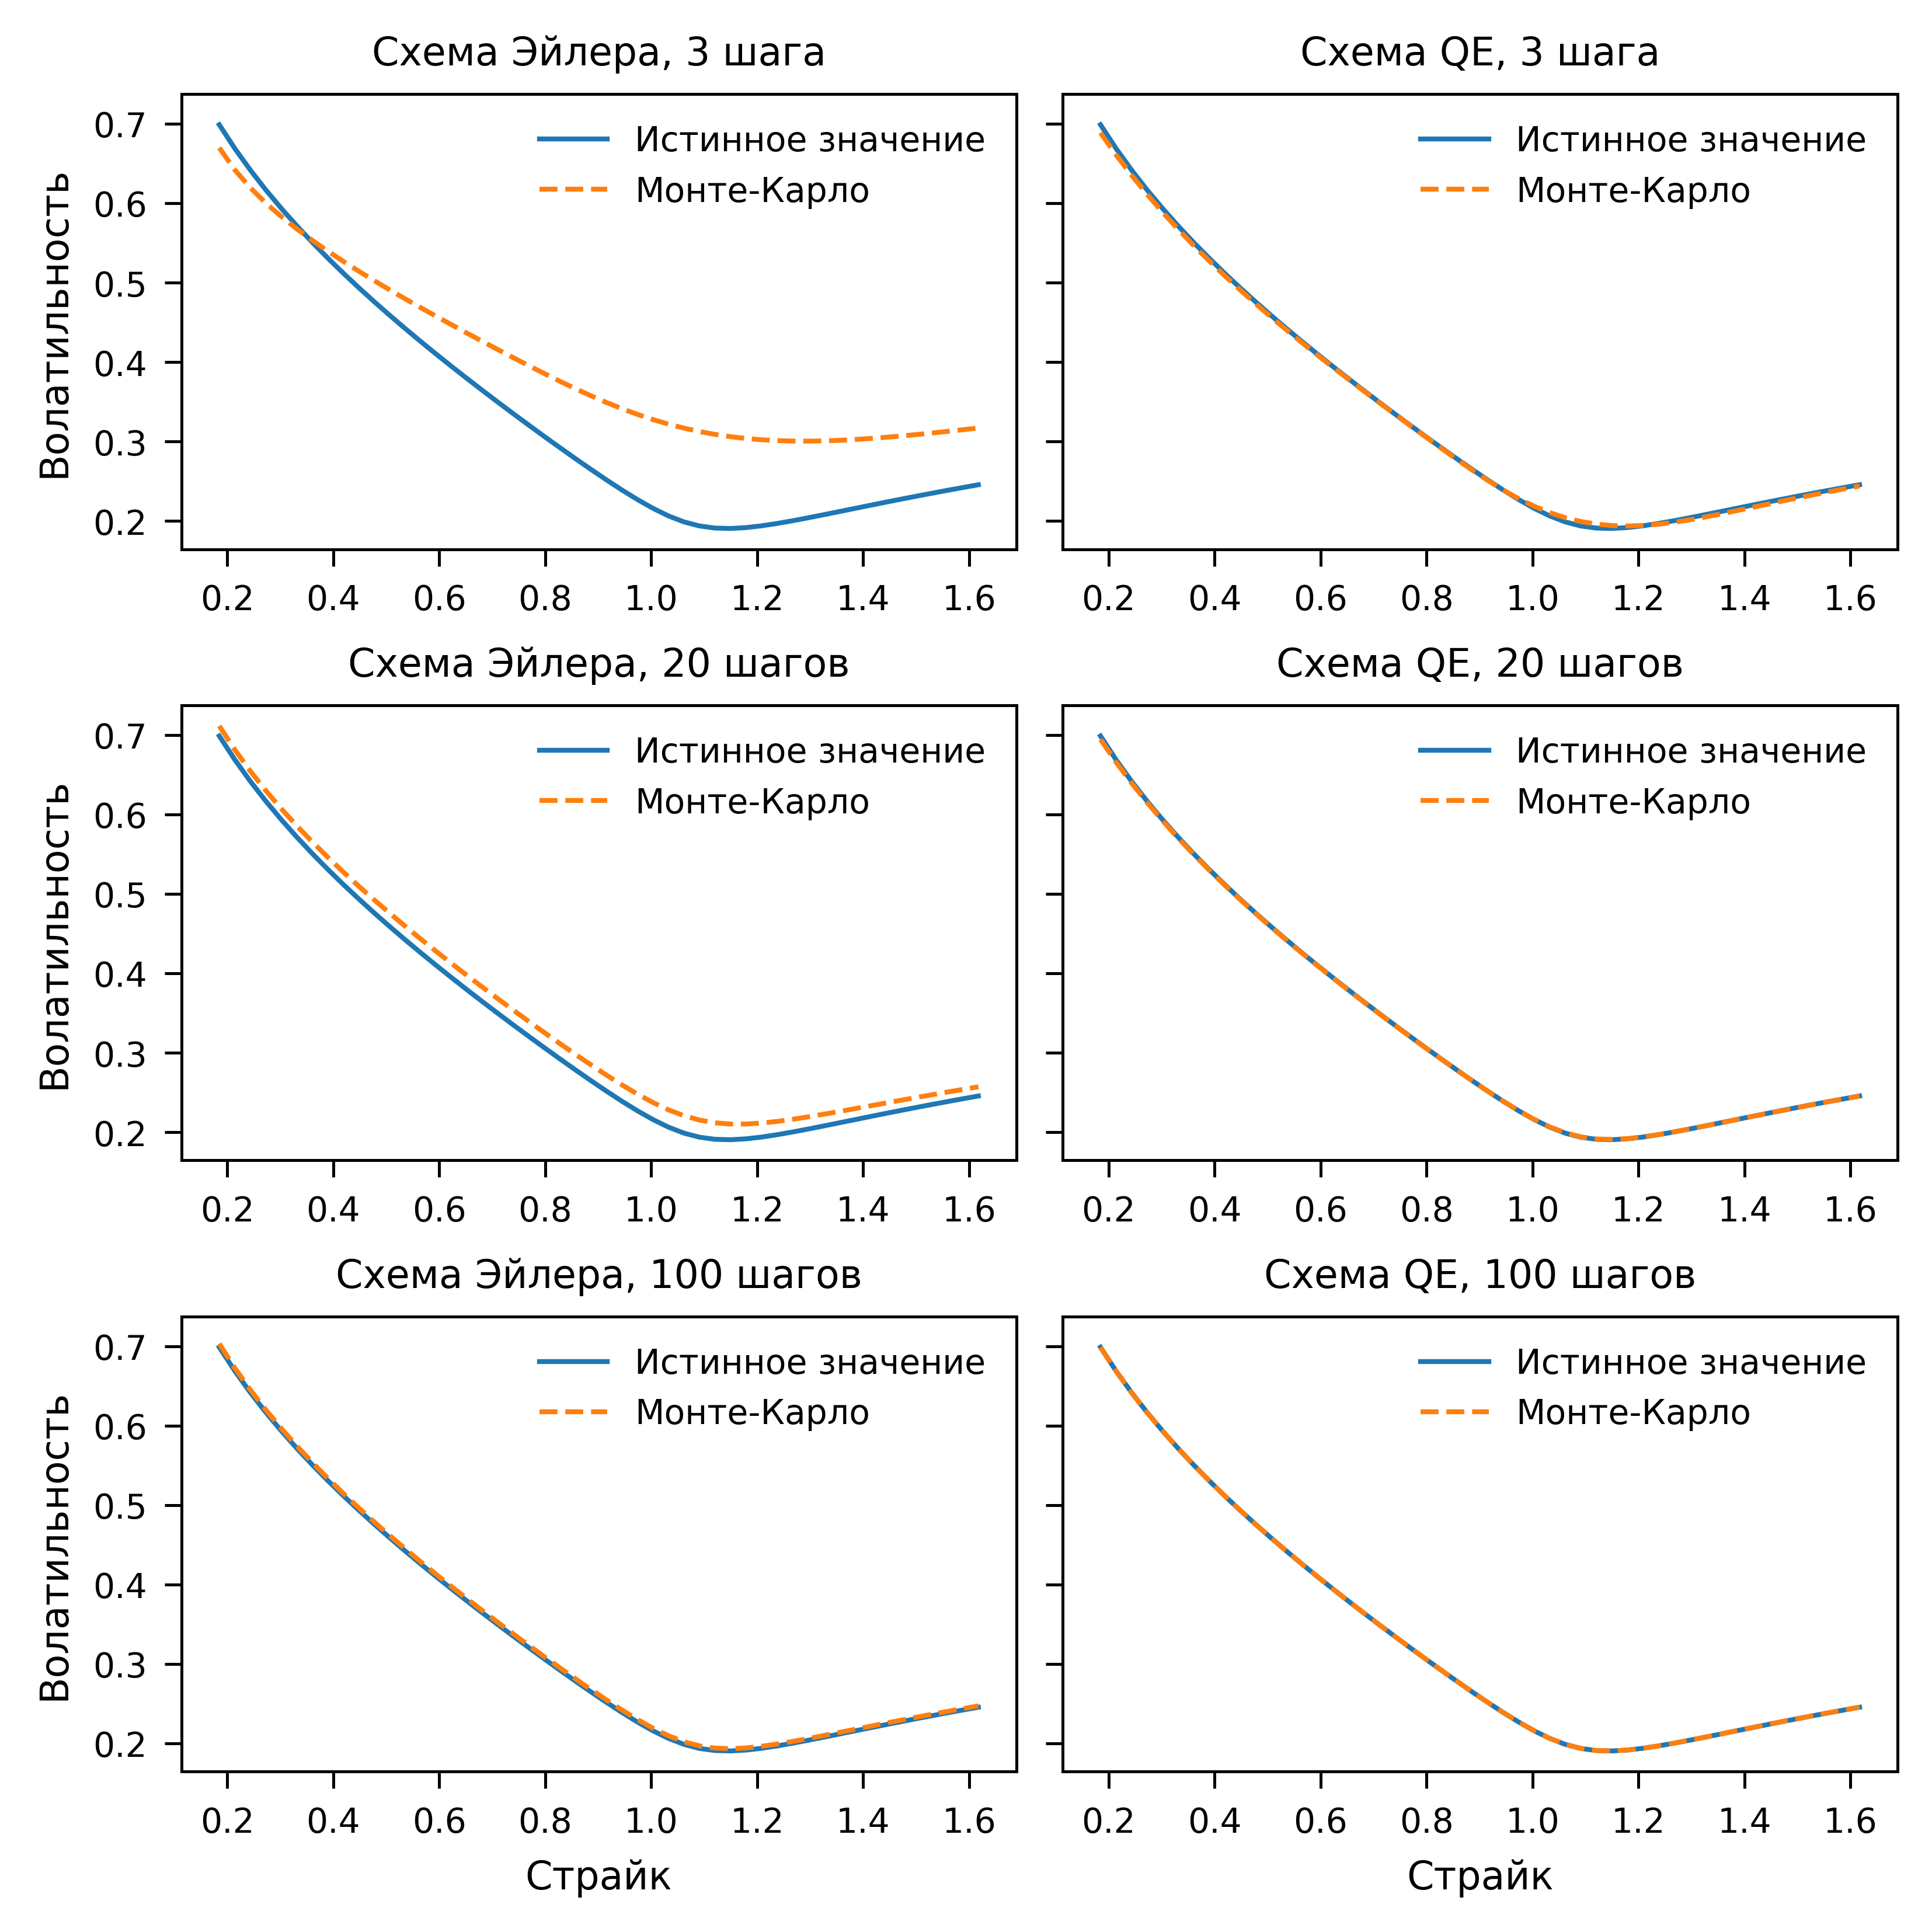

In [ ]:
# Сравнение схемы Эйлера и схемы QE
model = HestonExt(0.1, 1, 0.1, 1.5, -0.6)
fig, ax = plt.subplots(3, 2, figsize=(2.7*2*scale, 1.8*3*scale), constrained_layout=True, sharey=True)

t = 1
s0 = 1
K = np.linspace(model.quantile(s0, t, 0.01), model.quantile(s0, t, 0.99), 50)
IV = model.implied_vol(s0, t, K)
for i, steps in enumerate([3, 20, 100]):
    print(steps, 'steps:')
    res = fm.monte_carlo(lambda: np.maximum(np.subtract.outer(model.simulate_euler_gpu(s0, t, steps=1, intersteps=steps, paths=1_000_000)[-1], K), 0), 1000_000_000, rel_err=0.005)
    C = cp.asnumpy(res.x)
    IV_ = fm.implied_vol(s0, t, K, C)
    ax[i,0].plot(K, IV, label='Истинное значение')
    ax[i,0].plot(K, IV_, linestyle='dashed', label='Монте-Карло')
    ax[i,0].set_title(f'Схема Эйлера, {steps} шаг' + ('а' if steps < 5 else 'ов'))
    ax[i,0].legend(loc='upper right', frameon=False)    
    print('Euler sucess:', np.all(res.success), '| paths:', res.iterations)

    res = fm.monte_carlo(lambda: np.maximum(np.subtract.outer(model.simulate(s0, t, steps=1, intersteps=steps, paths=1_000_000, use_gpu=True)[-1], K), 0), 1000_000_000, rel_err=0.005)
    C = cp.asnumpy(res.x)
    IV_ = fm.implied_vol(s0, t, K, C)
    ax[i,1].plot(K, IV, label='Истинное значение')
    ax[i,1].plot(K, IV_, linestyle='dashed', label='Монте-Карло')
    ax[i,1].set_title(f'Схема QE, {steps} шаг' + ('а' if steps < 5 else 'ов'))
    ax[i,1].legend(loc='upper right', frameon=False)
    ax[i,0].set_ylabel('Волатильность')
    print('QE sucess:', np.all(res.success), '| paths:', res.iterations)
    print('---------------')

ax[2,0].set_xlabel('Страйк')
ax[2,1].set_xlabel('Страйк');